In [ ]:
!pip install np
import np
# Load the processed EEG signal samples and seizure labels
signals_file = r"/content/drive/MyDrive/AD Lab/AD-SEIZURE/processed_signal_samples_with_processed_used.npy"
labels_file = r"/content/drive/MyDrive/AD Lab/AD-SEIZURE/processed_is_sz_with_processed.npy"  # Corrected path

# Load the signal data
array_signals = np.load(signals_file)
array_is_sz = np.load(labels_file)

  Preparing metadata (setup.py) ... done
  Created wheel for np: filename=np-1.0.2-py3-none-any.whl size=13658 sha256=27248a1429b8b31856bc201884175114e5235c57af288cb54f090399992582c9
  Stored in directory: /root/.cache/pip/wheels/19/20/42/6ee214e617f78123903f603524d662ac6fa14154c3027fd992
Successfully built np


In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 54.9 MB/s eta 0:00:00


In [ ]:


import mne
import numpy as np
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt

# Check the shape of the data to ensure it's in the correct format
print(f"Shape of EEG signal data: {array_signals.shape}")
print(f"Shape of seizure labels: {array_is_sz.shape}")

# Step 1: Reshape the data from 3D (n_trials, n_channels, n_samples) to 2D (n_trials * n_samples, n_channels)
reshaped_signals = array_signals.reshape(-1, array_signals.shape[1])  # Shape (n_trials * n_samples, n_channels)

print(f"Shape of reshaped EEG signal data: {reshaped_signals.shape}")

# Convert reshaped EEG signals to float16 (note: may affect accuracy)
reshaped_signals = reshaped_signals.astype('float16')

# Step 2: Create an MNE Raw object
info = mne.create_info(ch_names=[f'Ch{i+1}' for i in range(array_signals.shape[1])],
                       sfreq=256,  # Adjust this to your actual sampling frequency
                       ch_types='eeg')

# Create an MNE Raw object with the reshaped signals
raw = mne.io.RawArray(reshaped_signals.T, info)

# Step 3: Apply FastICA analysis to remove artifacts (eye movements, muscle movements, etc.)
# Initialize the FastICA model from sklearn
ica = FastICA(n_components=18, random_state=42, max_iter=800)  # Specify the number of components

# Fit FastICA on the reshaped EEG data
ica_components = ica.fit_transform(reshaped_signals)

# Visualize the topographies of the ICA components
fig, ax = plt.subplots(6, 3, figsize=(12, 18))
for i in range(18):
    ax[i//3, i%3].plot(ica_components[:, i])
    ax[i//3, i%3].set_title(f'Component {i+1}')

plt.tight_layout()
plt.show()

# Optionally, you can also visualize the component mixing matrix (topographies) from FastICA
# You can use the components_ attribute to access the spatial patterns of each independent component
fig, ax = plt.subplots(6, 3, figsize=(12, 18))
for i in range(18):
    ax[i//3, i%3].plot(ica.components_[i, :])  # Plot the topography of component i
    ax[i//3, i%3].set_title(f'Component {i+1} (Topography)')

plt.tight_layout()
plt.show()


Shape of EEG signal data: (9505, 18, 2048)
Shape of seizure labels: (9505,)
Shape of reshaped EEG signal data: (19466240, 18)
Creating RawArray with float64 data, n_channels=18, n_times=19466240
    Range : 0 ... 19466239 =      0.000 ... 76039.996 secs
Ready.


In [ ]:
array_signals = array_signals[:, :, ::2]
ch_labels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3','P3-O1',
             'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2',
             'FZ-CZ', 'CZ-PZ']

In [ ]:
!pip install wfdb

#import numpy as np
import matplotlib.pyplot as plt
#import pyedflib
import wfdb
import glob
import random
import gc
import mne
from scipy.signal import find_peaks
import re
import tqdm
import logging

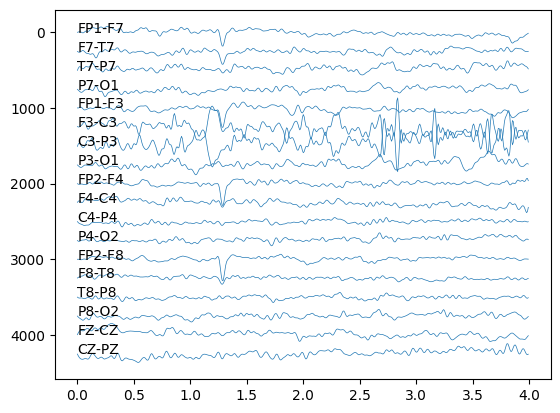

In [ ]:
# show a sample of extracted signals (the last one)

vertical_width = 250
signals = array_signals[-1, :, :]
fs = 128

fig, ax = plt.subplots()
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()

In [ ]:
# Checking how much of signals have seizure inside.

array_n = np.where(array_is_sz>.0)[0]
print('Number of all the extracted signals: {}'.format(array_is_sz.size))
print('Number of signals with seizures: {}'.format(array_n.size))
print('Ratio of signals with seizures: {:.3f}'.format(array_n.size/array_is_sz.size))

Number of all the extracted signals: 9505
Number of signals with seizures: 2581
Ratio of signals with seizures: 0.272


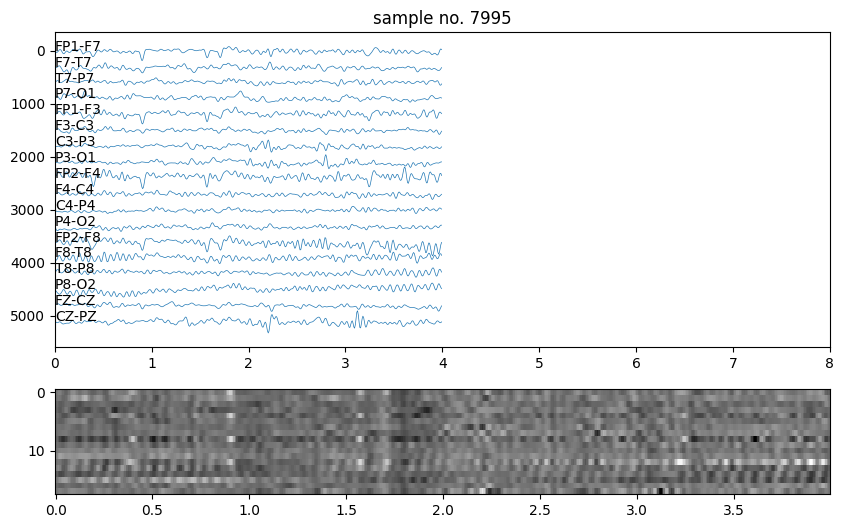

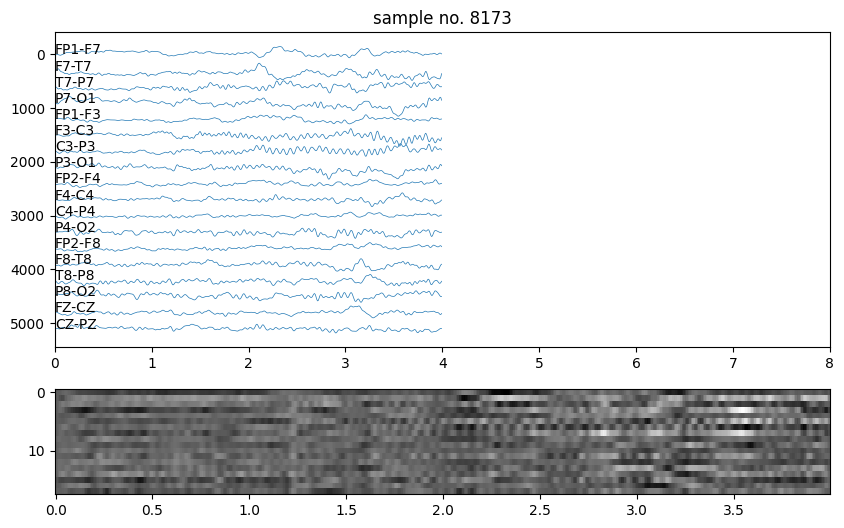

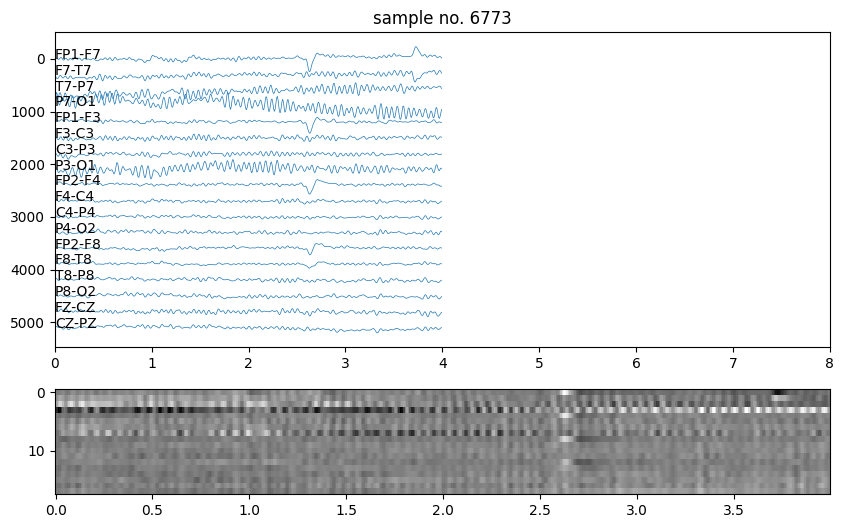

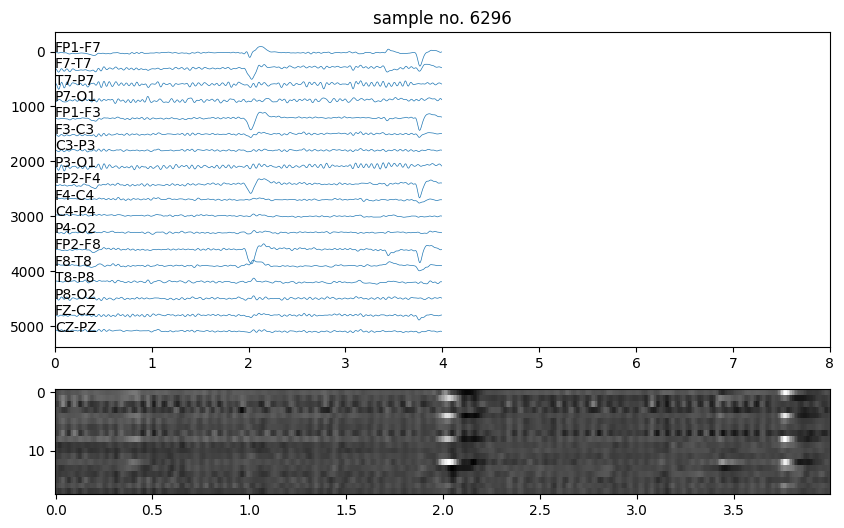

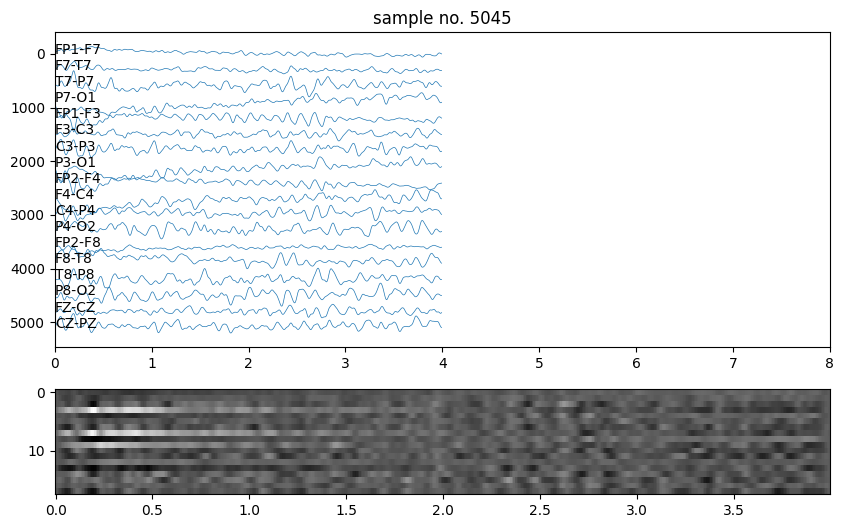

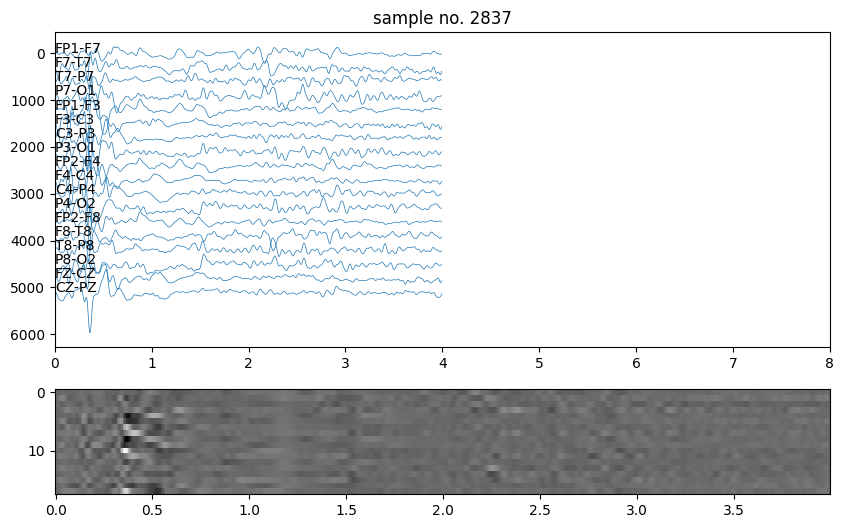

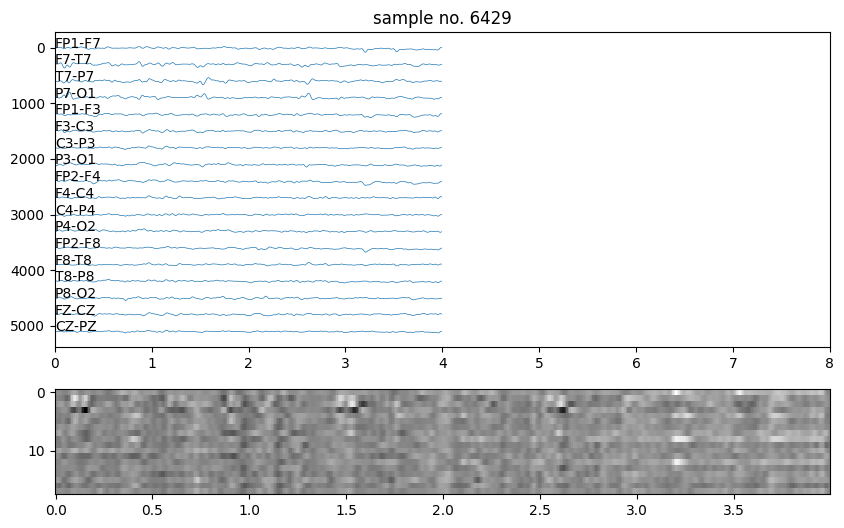

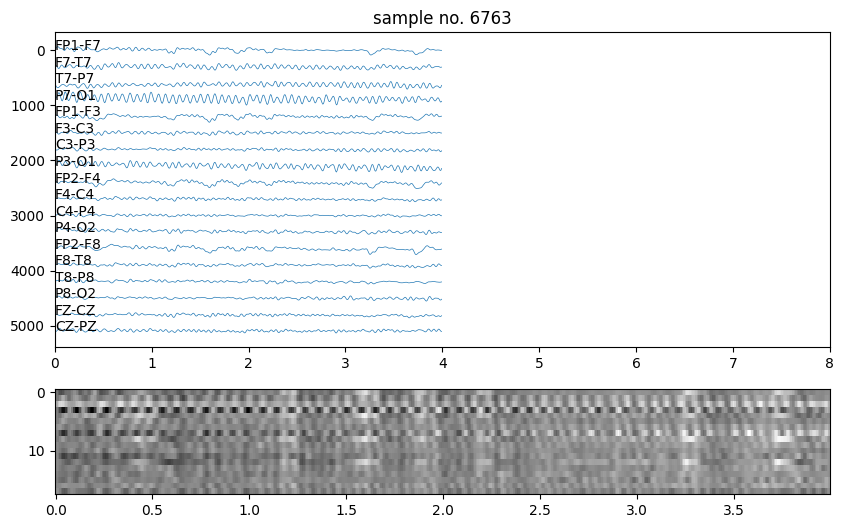

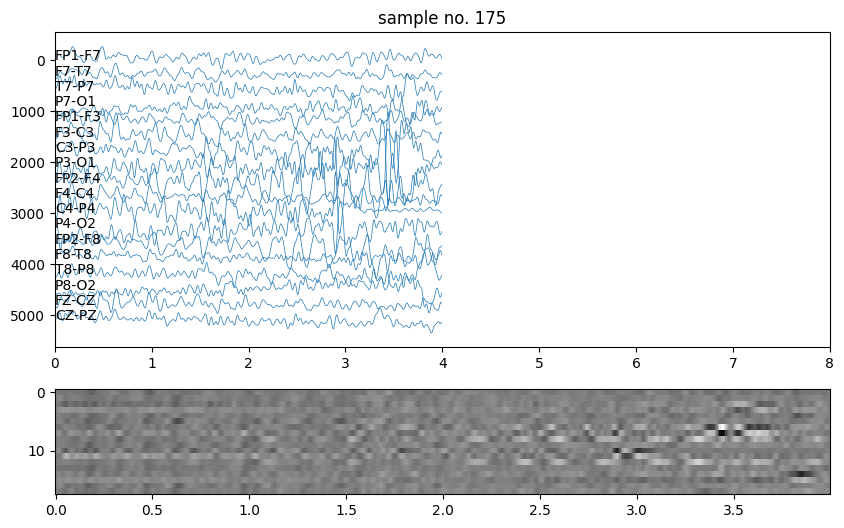

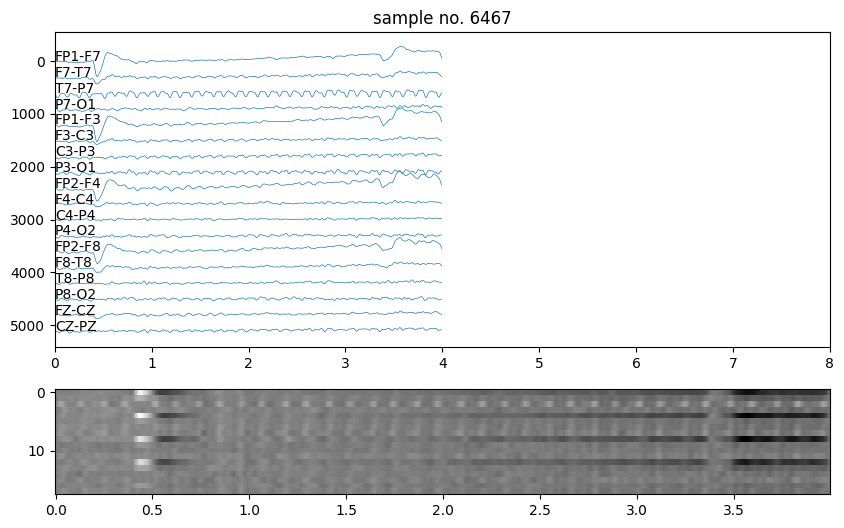

In [ ]:
# Let's see samples with seizures.

for n in random.sample(list(array_n), 10):

    vertical_width = 300
    temp_signals = array_signals[n, :, :]
    fs = 128

    fig, ax = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]})
    for i in range(temp_signals.shape[0]):
        ax[0].plot(np.arange(temp_signals.shape[-1])/fs, temp_signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
        ax[0].annotate(ch_labels[i], xy=(0, i*vertical_width))
    ax[0].invert_yaxis()
    ax[0].set_xlim(0, 8)
    ax[0].set_title('sample no. {}'.format(n))

    ax[1].pcolormesh(np.arange(temp_signals.shape[-1])/fs, np.arange(len(ch_labels)), temp_signals[:, :], cmap='gray')
    ax[1].invert_yaxis()

    plt.show()


In [ ]:
from sklearn import model_selection

In [ ]:
# CNN will be used. Channel dimension is added.
array_signals = array_signals[:, :, :, np.newaxis]

array_signals.shape

(9505, 18, 512, 1)

In [ ]:
# splitting training data into training & validation data.

X_train, X_val, y_train, y_val = model_selection.train_test_split(
    array_signals, array_is_sz, test_size=0.3,
    stratify=(array_is_sz>0))

del array_signals, array_is_sz

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
## deep learning model

model = keras.models.Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), strides=(1, 2),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((1, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), padding='same', activation='relu'))
model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), strides=(1, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=(4, 4), padding='same', activation='relu'))
model.add(layers.Conv2D(filters=256, kernel_size=(4, 4), strides=(1, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((1, 2)))

model.add(layers.GlobalAveragePooling2D())
#model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 18, 512, 64)         │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 18, 256, 64)         │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 18, 128, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 18, 128, 128)        │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 9, 32, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 9, 32, 256)          │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 9, 16, 256)          │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,910,657 (7.29 MB)

 Trainable params: 1,910,657 (7.29 MB)

 Non-trainable params: 0 (0.00 B)

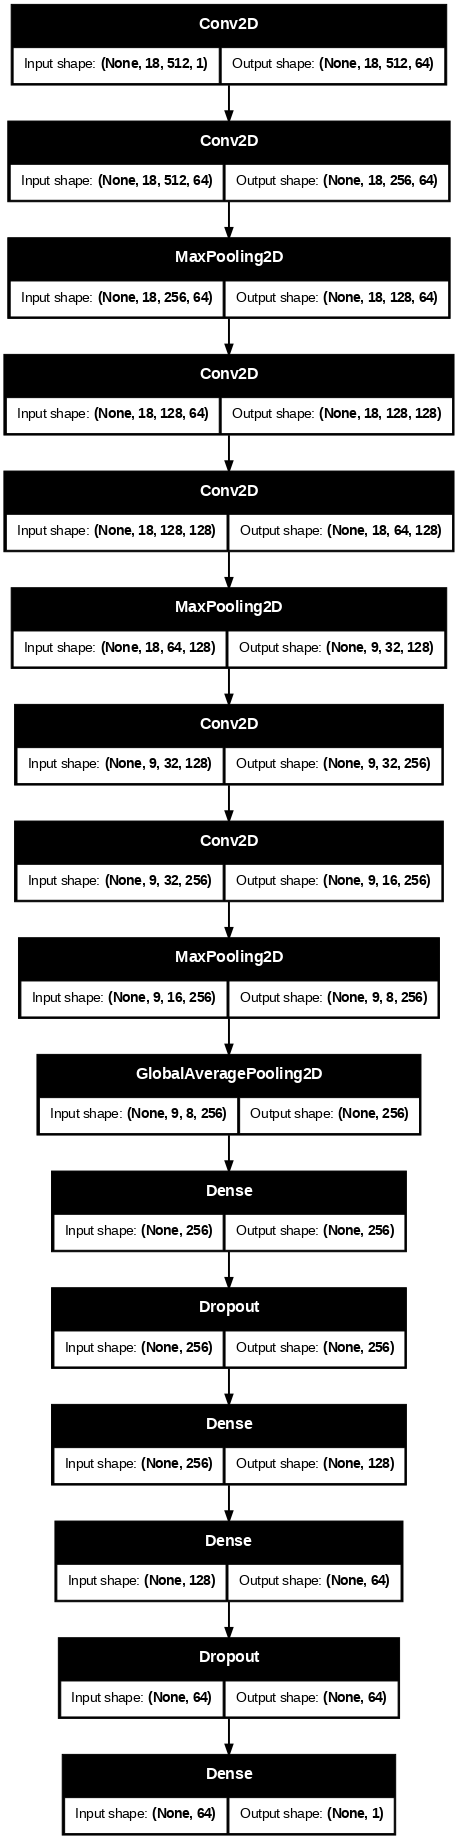

In [ ]:
from keras.utils import plot_model
#plot_model(model, show_shapes=True, to_file='model.png')
plot_model(model, show_shapes=True, dpi=70)


In [ ]:
LEARNING_RATE = 1e-4
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# callbacks
VERBOSE=1
#lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, verbose=VERBOSE, min_le=1e-8)
es = EarlyStopping(monitor='val_loss', patience=20, verbose=VERBOSE, mode='auto', restore_best_weights=True)

callbacks = [es]

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape


((6653, 18, 512, 1), (6653,), (2852, 18, 512, 1), (2852,))

In [ ]:
hist = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=256,
    callbacks=callbacks
)

Epoch 1/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.6225 - loss: 0.7392 - val_accuracy: 0.7286 - val_loss: 0.6708
Epoch 2/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 471ms/step - accuracy: 0.7150 - loss: 0.6702 - val_accuracy: 0.7384 - val_loss: 0.6506
Epoch 3/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 480ms/step - accuracy: 0.7346 - loss: 0.6314 - val_accuracy: 0.7581 - val_loss: 0.6064
Epoch 4/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 482ms/step - accuracy: 0.7598 - loss: 0.5952 - val_accuracy: 0.7949 - val_loss: 0.5396
Epoch 5/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 483ms/step - accuracy: 0.7767 - loss: 0.5558 - val_accuracy: 0.7759 - val_loss: 0.5642
Epoch 6/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 483ms/step - accuracy: 0.7787 - loss: 0.5424 - val_accuracy: 0.8086 - val_loss: 0.4864
Epoch 7/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 477ms/step - accuracy: 0.7896 - loss: 0.5152 - val_accuracy: 0.8198 - val_loss: 0.4484
Epoch 8/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 481ms/step - accuracy: 0.8158 - loss: 0.4626 - val

In [ ]:
model.save('/content/drive/MyDrive/AD Lab/AD-SEIZURE/CHB_MIT_sz_detec_demo.h5')


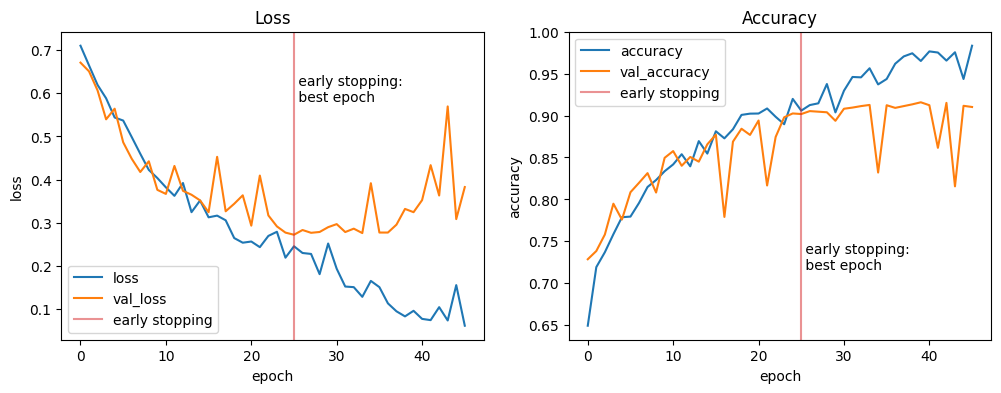

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(hist.history['loss'], label='loss')
ax[0].plot(hist.history['val_loss'], label='val_loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
r = .2
temp_y = r*min(hist.history['loss'])+(1-r)*max(hist.history['loss'])
ax[0].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(hist.history['accuracy'], label='accuracy')
ax[1].plot(hist.history['val_accuracy'], label='val_accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
r = .8
temp_y = r*min(hist.history['accuracy'])+(1-r)*max(hist.history['accuracy'])
ax[1].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
ax[1].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



import os

In [ ]:
!pip install wfdb
!pip install mne

In [ ]:
#import numpy as np
import matplotlib.pyplot as plt
#import pyedflib
import wfdb
import glob
import random
import gc
import mne
from scipy.signal import find_peaks
import re
import tqdm
import logging

In [ ]:
ch_labels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3','P3-O1',
             'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2',
             'FZ-CZ', 'CZ-PZ']

In [ ]:
import glob
import os

# Correctly defining the path using raw string
path2pt = r"/content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0"

# Use os.path.join to build the path and ensure correct separators
folders = sorted(glob.glob(os.path.join(path2pt, '*/')))

# Extract patient folder names
n_patient = [os.path.basename(os.path.normpath(folder))[-2:] for folder in folders]

# Print the patient numbers
print(*n_patient)

01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24


In [ ]:
random.seed(2023)

ratio_train = 0.8
train_patient_str = sorted(random.sample(n_patient, round(ratio_train*len(n_patient))))
test_patient_str = sorted([l for l in n_patient if l not in train_patient_str])
print('Train PT: ', *train_patient_str)
print('Test PT: ', *test_patient_str)

Train PT:  02 03 04 05 06 09 11 12 13 14 15 16 17 18 19 20 21 23 24
Test PT:  01 07 08 10 22


In [ ]:
# file names for training and test data

files_train = []
for l in train_patient_str:
    files_train = files_train + glob.glob(path2pt+'/chb{}/*.edf'.format(l))

files_test = []
for l in test_patient_str:
    files_test = files_test + glob.glob(path2pt+'/chb{}/*.edf'.format(l))

In [ ]:
len(files_train), len(files_test)

(549, 137)

In [ ]:
def sampling_data_pred(f, verbose=True):
    list_signals = []
    list_is_sz = []
    #n_sample = 40
    if verbose==True:
        print('{}: Reading. '.format(f))
    temp_edf =  mne.io.read_raw_edf(f)
    temp_labels = temp_edf.ch_names
    if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)
        #temp_edf = temp_edf.pick(ch_labels)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

        if os.path.exists(f+'.seizures'):
            if verbose==True:
                print('sz exists.', end=' ')
            temp_annotation = wfdb.rdann(f, 'seizures')
            for i in range(int(temp_annotation.sample.size/2)):
                temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
        #else:
            #print('No sz.', end=' ')

        temp_len = temp_edf.n_times

        time_window = 8
        time_step = 4
        fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
        step_window = time_window*fs
        step = time_step*fs

        # sampling all signals
        temp_array_signals = np.array([temp_signals[:, i*step:i*step+step_window] for i in range((temp_len-step_window)//step)])
        temp_is_sz_ind = np.array([temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)])
    else:
        if verbose==True:
            print('EEG {}: Not appropriate channel labels. Reading skipped.'.format(n))

    return temp_array_signals, temp_is_sz_ind

In [ ]:
# reading files and prediction

list_pred = []
list_true = []

for f in tqdm.tqdm(files_test):
    array_signals, array_is_sz = sampling_data_pred(f, verbose=False)
    array_signals = array_signals[:, :, ::2, np.newaxis]

    list_pred.append(model.predict(array_signals, verbose=0))
    list_true.append(array_is_sz)

  0%|          | 0/137 [00:00<?, ?it/s]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
  1%|          | 1/137 [00:08<20:09,  8.89s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
  1%|▏         | 2/137 [00:12<13:40,  6.08s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
  2%|▏         | 3/137 [00:17<12:12,  5.47s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
  3%|▎         | 4/137 [00:21<10:53,  4.91s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
  4%|▎         | 5/137 [00:25<09:44,  4.43s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
  4%|▍         | 6/137 [00:29<09:24,  4.31s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
  5%|▌         | 7/137 [00:33<08:53,  4.10s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
  6%|▌         | 8/137 [00:37<08:54,  4.14s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
  7%|▋         | 9/137 [00:41<09:03,  4.25s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
  7%|▋         | 10/137 [00:45<08:29,  4.01s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
  8%|▊         | 11/137 [00:49<08:23,  3.99s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
  9%|▉         | 12/137 [00:53<08:22,  4.02s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
  9%|▉         | 13/137 [00:56<08:02,  3.90s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 10%|█         | 14/137 [01:00<07:46,  3.79s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 11%|█         | 15/137 [01:05<08:09,  4.01s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 12%|█▏        | 16/137 [01:09<08:34,  4.25s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 12%|█▏        | 17/137 [01:13<08:19,  4.17s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 13%|█▎        | 18/137 [01:19<09:11,  4.64s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 14%|█▍        | 19/137 [01:24<09:17,  4.72s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 15%|█▍        | 20/137 [01:32<11:05,  5.69s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 15%|█▌        | 21/137 [01:37<10:32,  5.45s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 16%|█▌        | 22/137 [01:41<09:28,  4.95s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 17%|█▋        | 23/137 [01:45<08:55,  4.70s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 18%|█▊        | 24/137 [01:49<08:35,  4.57s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 18%|█▊        | 25/137 [01:52<07:50,  4.20s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 19%|█▉        | 26/137 [01:56<07:18,  3.95s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 20%|█▉        | 27/137 [02:01<07:54,  4.31s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 20%|██        | 28/137 [02:05<07:36,  4.19s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 21%|██        | 29/137 [02:09<07:27,  4.14s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 22%|██▏       | 30/137 [02:13<07:22,  4.14s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 23%|██▎       | 31/137 [02:17<07:31,  4.26s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 23%|██▎       | 32/137 [02:22<07:22,  4.21s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_34.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 24%|██▍       | 33/137 [02:26<07:35,  4.38s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 25%|██▍       | 34/137 [02:31<07:30,  4.37s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_37.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 26%|██▌       | 35/137 [02:35<07:23,  4.35s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 26%|██▋       | 36/137 [02:39<07:06,  4.22s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_39.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 27%|██▋       | 37/137 [02:43<06:45,  4.06s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_40.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 28%|██▊       | 38/137 [02:46<06:32,  3.97s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_41.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 28%|██▊       | 39/137 [02:51<06:37,  4.06s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_42.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 29%|██▉       | 40/137 [02:54<06:24,  3.96s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_43.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 30%|██▉       | 41/137 [02:59<06:35,  4.12s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_46.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 31%|███       | 42/137 [03:03<06:47,  4.29s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 31%|███▏      | 43/137 [03:14<09:47,  6.25s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 32%|███▏      | 44/137 [03:26<12:04,  7.79s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 33%|███▎      | 45/137 [03:37<13:24,  8.75s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 34%|███▎      | 46/137 [03:48<14:14,  9.39s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 34%|███▍      | 47/137 [04:00<15:28, 10.31s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 35%|███▌      | 48/137 [04:06<13:24,  9.04s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 36%|███▌      | 49/137 [04:15<13:04,  8.91s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 36%|███▋      | 50/137 [04:25<13:37,  9.40s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 37%|███▋      | 51/137 [04:34<13:14,  9.24s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 38%|███▊      | 52/137 [04:44<13:09,  9.29s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 39%|███▊      | 53/137 [04:53<13:03,  9.33s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 39%|███▉      | 54/137 [05:06<14:15, 10.31s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 40%|████      | 55/137 [05:11<12:16,  8.98s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 41%|████      | 56/137 [05:22<12:34,  9.31s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 42%|████▏     | 57/137 [05:32<12:49,  9.62s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 42%|████▏     | 58/137 [05:44<13:28, 10.24s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 43%|████▎     | 59/137 [05:52<12:28,  9.60s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 44%|████▍     | 60/137 [06:02<12:46,  9.96s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 45%|████▍     | 61/137 [06:16<13:56, 11.00s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 45%|████▌     | 62/137 [06:19<10:58,  8.78s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 46%|████▌     | 63/137 [06:24<09:07,  7.39s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 47%|████▋     | 64/137 [06:27<07:41,  6.32s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 47%|████▋     | 65/137 [06:32<06:47,  5.66s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 48%|████▊     | 66/137 [06:35<05:48,  4.91s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 49%|████▉     | 67/137 [06:39<05:32,  4.76s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 50%|████▉     | 68/137 [06:43<05:13,  4.54s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 50%|█████     | 69/137 [06:48<05:12,  4.60s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 51%|█████     | 70/137 [06:52<04:54,  4.39s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 52%|█████▏    | 71/137 [06:56<04:38,  4.22s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 53%|█████▎    | 72/137 [07:00<04:33,  4.21s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 53%|█████▎    | 73/137 [07:04<04:28,  4.19s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 54%|█████▍    | 74/137 [07:09<04:35,  4.37s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 55%|█████▍    | 75/137 [07:12<04:19,  4.19s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 55%|█████▌    | 76/137 [07:16<04:05,  4.03s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 56%|█████▌    | 77/137 [07:21<04:23,  4.38s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 57%|█████▋    | 78/137 [07:26<04:27,  4.53s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 58%|█████▊    | 79/137 [07:30<04:13,  4.37s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 58%|█████▊    | 80/137 [07:34<03:52,  4.08s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 59%|█████▉    | 81/137 [07:39<04:05,  4.39s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 60%|█████▉    | 82/137 [07:45<04:35,  5.01s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 61%|██████    | 83/137 [07:53<05:08,  5.72s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 61%|██████▏   | 84/137 [07:58<05:05,  5.77s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 62%|██████▏   | 85/137 [08:06<05:21,  6.18s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 63%|██████▎   | 86/137 [08:11<05:08,  6.05s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 64%|██████▎   | 87/137 [08:17<04:54,  5.88s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 64%|██████▍   | 88/137 [08:23<04:57,  6.07s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 65%|██████▍   | 89/137 [08:29<04:44,  5.93s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 66%|██████▌   | 90/137 [08:35<04:45,  6.07s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 66%|██████▋   | 91/137 [08:41<04:36,  6.01s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 67%|██████▋   | 92/137 [08:48<04:41,  6.26s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 68%|██████▊   | 93/137 [08:55<04:39,  6.36s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 69%|██████▊   | 94/137 [09:01<04:38,  6.47s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 69%|██████▉   | 95/137 [09:07<04:22,  6.25s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 70%|███████   | 96/137 [09:14<04:21,  6.37s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 71%|███████   | 97/137 [09:21<04:21,  6.55s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 72%|███████▏  | 98/137 [09:30<04:49,  7.42s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 72%|███████▏  | 99/137 [09:35<04:17,  6.78s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 73%|███████▎  | 100/137 [09:41<03:58,  6.45s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 74%|███████▎  | 101/137 [09:51<04:30,  7.50s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 74%|███████▍  | 102/137 [09:57<04:07,  7.09s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 75%|███████▌  | 103/137 [10:03<03:52,  6.84s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 76%|███████▌  | 104/137 [10:10<03:44,  6.79s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 77%|███████▋  | 105/137 [10:17<03:36,  6.76s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_89.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 77%|███████▋  | 106/137 [10:24<03:29,  6.76s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 78%|███████▊  | 107/137 [10:28<02:57,  5.91s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 79%|███████▉  | 108/137 [10:31<02:31,  5.22s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 80%|███████▉  | 109/137 [10:35<02:17,  4.91s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 80%|████████  | 110/137 [10:39<02:05,  4.64s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 81%|████████  | 111/137 [10:43<01:55,  4.45s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 82%|████████▏ | 112/137 [10:47<01:46,  4.25s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 82%|████████▏ | 113/137 [10:51<01:41,  4.22s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 83%|████████▎ | 114/137 [10:55<01:33,  4.06s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 84%|████████▍ | 115/137 [10:59<01:28,  4.00s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 85%|████████▍ | 116/137 [11:03<01:24,  4.02s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 85%|████████▌ | 117/137 [11:08<01:24,  4.22s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 86%|████████▌ | 118/137 [11:12<01:18,  4.13s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 87%|████████▋ | 119/137 [11:16<01:16,  4.24s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 88%|████████▊ | 120/137 [11:20<01:11,  4.23s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 88%|████████▊ | 121/137 [11:24<01:06,  4.15s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 89%|████████▉ | 122/137 [11:28<01:00,  4.01s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 90%|████████▉ | 123/137 [11:32<00:57,  4.08s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 91%|█████████ | 124/137 [11:36<00:52,  4.05s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 91%|█████████ | 125/137 [11:40<00:47,  4.00s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 92%|█████████▏| 126/137 [11:45<00:45,  4.16s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 93%|█████████▎| 127/137 [11:48<00:39,  3.97s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 93%|█████████▎| 128/137 [11:53<00:38,  4.29s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 94%|█████████▍| 129/137 [11:57<00:33,  4.21s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 95%|█████████▍| 130/137 [12:01<00:28,  4.03s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 96%|█████████▌| 131/137 [12:04<00:23,  3.85s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 96%|█████████▋| 132/137 [12:08<00:18,  3.75s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 97%|█████████▋| 133/137 [12:12<00:15,  3.92s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 98%|█████████▊| 134/137 [12:16<00:12,  4.09s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_51.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 99%|█████████▊| 135/137 [12:20<00:08,  4.02s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_54.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
 99%|█████████▉| 136/137 [12:24<00:03,  3.87s/it]

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_77.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)
100%|██████████| 137/137 [12:28<00:00,  5.46s/it]


In [ ]:
from sklearn import metrics

In [ ]:
# threshold = 0.5
report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.5)
print(report)

              precision    recall  f1-score   support

       False       1.00      0.78      0.88    186865
        True       0.01      0.45      0.01       629

    accuracy                           0.78    187494
   macro avg       0.50      0.61      0.44    187494
weighted avg       0.99      0.78      0.87    187494



In [ ]:
# threshold = 0.9
report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.9)
print(report)

              precision    recall  f1-score   support

       False       1.00      0.93      0.96    186865
        True       0.02      0.32      0.03       629

    accuracy                           0.93    187494
   macro avg       0.51      0.63      0.50    187494
weighted avg       0.99      0.93      0.96    187494



In [ ]:
roc = metrics.roc_curve(np.concatenate(list_true)>0, np.concatenate(list_pred))
auc = metrics.roc_auc_score(np.concatenate(list_true)>0, np.concatenate(list_pred))

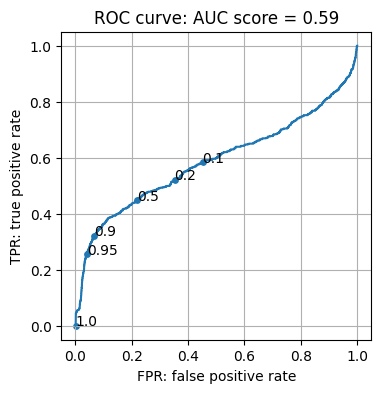

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(roc[0][np.argmin(np.abs(roc[2]-1)):], roc[1][np.argmin(np.abs(roc[2]-1)):])
plt.xlabel('FPR: false positive rate')
plt.ylabel('TPR: true positive rate')
plt.title('ROC curve: AUC score = {:.2f}'.format(auc))

th = [.1, .2, .5, .9, .95, 1.]
ind = [np.argmin(np.abs(roc[2]-l)) for l in th]
plt.scatter(roc[0][ind], roc[1][ind], s=15)
for i, l in enumerate(ind):
    plt.annotate("{}".format(th[i]), xy=(roc[0][l], roc[1][l]))
#plt.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], color='black', linewidth=1)
plt.ylim(-.05, 1.05)
plt.xlim(-.05, 1.05)
plt.grid()
#plt.axis('off')
plt.show()

In [ ]:
for i, f in enumerate(files_test):
    if os.path.exists(f+'.seizures'):
        print('Index = {} has seizures: {}'.format(i, f))

Index = 2 has seizures: /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_03.edf
Index = 3 has seizures: /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_04.edf
Index = 14 has seizures: /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_15.edf
Index = 15 has seizures: /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_16.edf
Index = 17 has seizures: /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_18.edf
Index = 20 has seizures: /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_21.edf
Index = 26 has seizures: /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_26.edf
Index = 53 has seizures: /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_12.edf
Index = 54 has seizures: /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_13.edf
Index = 60 has seizures: /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_19.edf
In

In [ ]:

def moving_ave(a, n):
    if len(a.shape)!=1:
        print('Not 1 dimension array. return nothing.')
        return
    temp = np.zeros(a.size-n)
    for i in range(n):
        temp = temp+a[i:-n+i]
    temp = temp/n

    return temp

In [ ]:
# get signals and labels from test data.
n=100
array_signals, array_is_sz = sampling_data_pred(files_test[n])

# preprocess
array_signals=array_signals[:, :, ::2, np.newaxis]

# use deep learning model
pred = model.predict(array_signals)

/content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_27.edf: Reading. 
Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-37-0dedb3a51db0>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


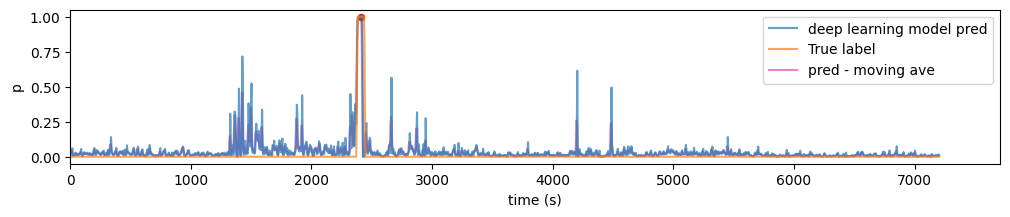

In [ ]:
time_window = 8
time_step = 4
mv_win = 3

fig, ax = plt.subplots(figsize=(12, 2))

ax.plot(np.arange(pred.size)*time_step, pred.flatten(), alpha=0.7, label='deep learning model pred')
ax.plot(np.arange(pred.size)*time_step, array_is_sz, alpha=.7, label='True label')

pred_moving_ave = moving_ave(pred.flatten(), mv_win)
pred_peaks, _ = find_peaks(pred_moving_ave, height=.95, distance=6)
ax.plot(np.arange(pred.size-mv_win)*time_step, pred_moving_ave,
        alpha=.9, label='pred - moving ave', color='tab:pink', zorder=0)
ax.scatter(pred_peaks*time_step, pred_moving_ave[pred_peaks], s=20, color='tab:red')

ax.set_xlabel('time (s)')
ax.set_ylabel('p')
ax.set_xlim(0, pred.size*time_step+500)
ax.legend(loc='upper right')
plt.show()

Extracting EDF parameters from /content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-49-90147032a885>:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  temp_edf =  mne.io.read_raw_edf(f)


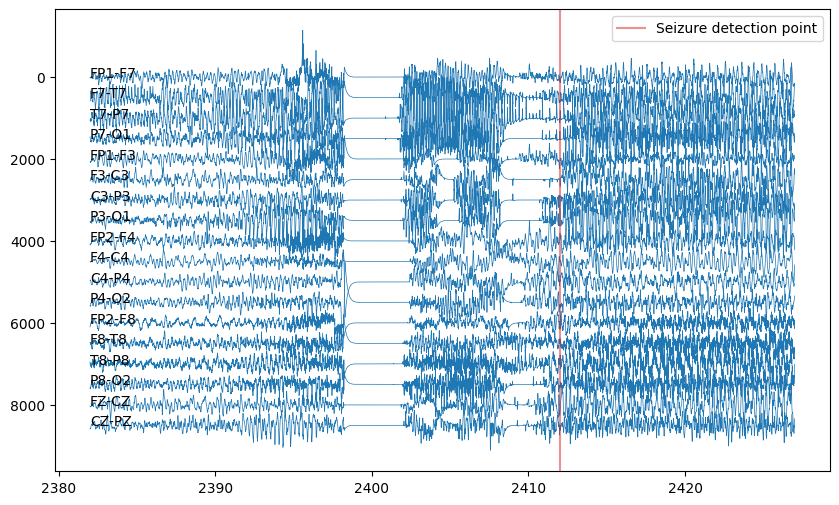

In [ ]:
if pred_peaks.size==0:
    print('No seizure detected.')
else:
    f = files_test[n]
    temp_edf =  mne.io.read_raw_edf(f)
    temp_labels = temp_edf.ch_names
    if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)
        #temp_edf = temp_edf.pick(ch_labels)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

    fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
    for n_peak in range(pred_peaks.size):
        ind_peak = pred_peaks[n_peak]*time_step*fs
        backward_steps = 30*fs
        forward_steps = 15*fs
        vertical_width=500

        fig, ax = plt.subplots(figsize=(10, 6))
        for i in range(temp_signals.shape[0]):
            ax.plot(np.arange(ind_peak-backward_steps, ind_peak+forward_steps)/fs,
                    temp_signals[i, ind_peak-backward_steps:ind_peak+forward_steps]+i*vertical_width, linewidth=0.5, color='tab:blue')
            ax.annotate(ch_labels[i], xy=((ind_peak-backward_steps)/fs, i*vertical_width))
        ax.axvline(x=ind_peak/fs, color='tab:red', alpha=0.5, label='Seizure detection point')
        ax.invert_yaxis()
        ax.legend(loc='upper right')
        plt.show()
    #ax.set_xlim(0, 8)

    temp_edf.close()
